<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_03_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

In [2]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

load nursing notes subject-caregiver-chartdate

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


In [6]:
patients = "PATIENTS.csv"
df_patients = pd.read_csv(notes_path+patients)
df_patients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [7]:
ward_name = "ICUSTAYS.csv"
df_ward = pd.read_csv(notes_path+ward_name)
df_ward.info()
df_ward['FIRST_CAREUNIT'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


array(['MICU', 'CCU', 'NICU', 'TSICU', 'SICU', 'CSRU'], dtype=object)

## **Data Preprocessing**

analyzing words in future dataset

In [8]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


imports for counting words

In [9]:
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


Grab tsicu notes

In [10]:
# get new type of notes (TSICU)
df_notes_TSICU = df_notes.merge(df_ward, on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_patients, on='SUBJECT_ID')

df_notes_TSICU = df_notes_TSICU[df_notes_TSICU['FIRST_CAREUNIT'] == 'TSICU']
df_notes_TSICU.info()
df_notes_TSICU.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64489 entries, 3299 to 908600
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID_x        64489 non-null  int64  
 1   SUBJECT_ID      64489 non-null  int64  
 2   CGID            64489 non-null  int64  
 3   CHARTDATE       64489 non-null  object 
 4   TEXT            64489 non-null  object 
 5   ROW_ID_y        64489 non-null  int64  
 6   HADM_ID         64489 non-null  int64  
 7   ICUSTAY_ID      64489 non-null  int64  
 8   DBSOURCE        64489 non-null  object 
 9   FIRST_CAREUNIT  64489 non-null  object 
 10  LAST_CAREUNIT   64489 non-null  object 
 11  FIRST_WARDID    64489 non-null  int64  
 12  LAST_WARDID     64489 non-null  int64  
 13  INTIME          64489 non-null  object 
 14  OUTTIME         64489 non-null  object 
 15  LOS             64489 non-null  float64
 16  ROW_ID          64489 non-null  int64  
 17  GENDER          64489 non-n

,ROW_ID_x,SUBJECT_ID,CGID,CHARTDATE,TEXT,ROW_ID_y,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,...,INTIME,OUTTIME,LOS,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
3299,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,10680,114444,239553,carevue,TSICU,...,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,7950,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3301,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,10680,114444,239553,carevue,TSICU,...,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,7950,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3303,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",10680,114444,239553,carevue,TSICU,...,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,7950,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3305,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,10680,114444,239553,carevue,TSICU,...,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,7950,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1
3307,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,10680,114444,239553,carevue,TSICU,...,2149-04-25 22:04:41,2149-05-22 14:04:55,26.6668,7950,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1


In [11]:
len(df_notes_TSICU['CGID'].unique())
deceased_TSICU = df_notes_TSICU[df_notes_TSICU['EXPIRE_FLAG'] == 1]
deceased_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37373 entries, 3299 to 908271
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID_x        37373 non-null  int64  
 1   SUBJECT_ID      37373 non-null  int64  
 2   CGID            37373 non-null  int64  
 3   CHARTDATE       37373 non-null  object 
 4   TEXT            37373 non-null  object 
 5   ROW_ID_y        37373 non-null  int64  
 6   HADM_ID         37373 non-null  int64  
 7   ICUSTAY_ID      37373 non-null  int64  
 8   DBSOURCE        37373 non-null  object 
 9   FIRST_CAREUNIT  37373 non-null  object 
 10  LAST_CAREUNIT   37373 non-null  object 
 11  FIRST_WARDID    37373 non-null  int64  
 12  LAST_WARDID     37373 non-null  int64  
 13  INTIME          37373 non-null  object 
 14  OUTTIME         37373 non-null  object 
 15  LOS             37373 non-null  float64
 16  ROW_ID          37373 non-null  int64  
 17  GENDER          37373 non-n

number of notes: min=1, max=124, mean=2.246648632401563,  median=1.0


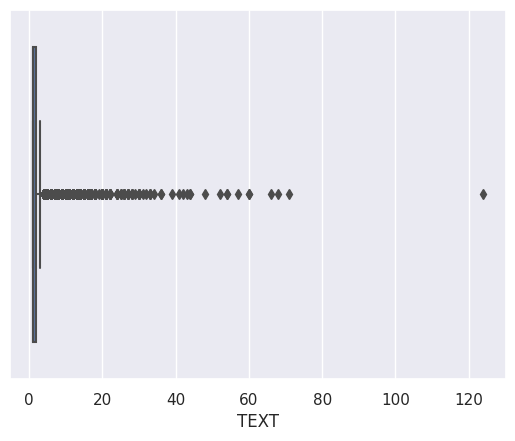

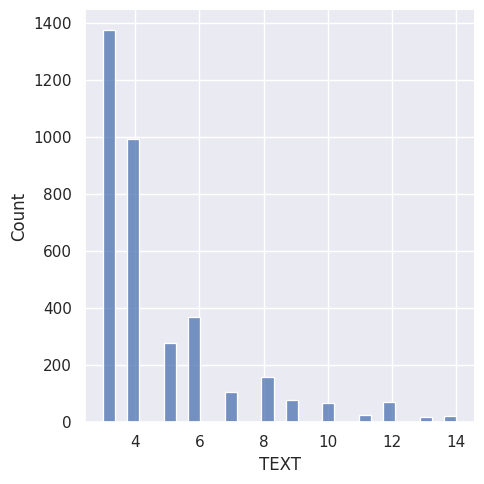

In [28]:
import seaborn as sns
sns.set()


gb_notes = deceased_TSICU.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

Tokenized words

In [12]:
text = df_notes_TSICU['TEXT'].str.cat(sep=' ')
words = nltk.word_tokenize(text)  # very slow

Count words in notes

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
words = [word.lower() for word in words if word.lower() not in stopwords and re.match(r'\b\w+\b', word)]  # also slow but only kinda slow
word_counts = Counter(words)
most_common_words = word_counts.most_common(300)

In [14]:
print("Rank\tWord\t\t\tCount")
for rank, word_count in enumerate(most_common_words, start=1):
  word, count = word_count
  print(f"{rank}\t{word.ljust(20)}\t{count}")

Rank	Word			Count
1	pt                  	233934
2	name                	80561
3	neuro               	50021
4	pain                	46231
5	resp                	46147
6	last                	44212
7	w/                  	43408
8	clear               	41598
9	skin                	41015
10	given               	40421
11	noted               	39361
12	plan                	39199
13	remains             	38264
14	ni                  	37903
15	abd                 	37879
16	today               	37056
17	hr                  	35193
18	cont                	34830
19	family              	34374
20	per                 	33163
21	intact              	32685
22	stable              	32535
23	monitor             	32259
24	gi                  	32161
25	urine               	31159
26	note                	29924
27	cv                  	29359
28	bp                  	28695
29	bs                  	28635
30	secretions          	28519
31	yellow              	28268
32	thick               	27445
33	care                	27319


Inverse Document Frequency

In [15]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_notes_TSICU['TEXT'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_score_dict = dict(zip(feature_names, tfidf_scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:50]

In [16]:
print("Rank\tWord\t\t\tCount")
for rank, (word, score) in enumerate(top_words, start=1):
  print(f"{rank}\t{word.ljust(20)}\t{score}")

Rank	Word			Count
1	pt                  	5120.6346907039715
2	hr                  	1985.533230799199
3	remains             	1522.365676633596
4	pain                	1467.9090567022035
5	cont                	1418.4796590824176
6	resp                	1405.1509409334062
7	ni                  	1380.3922807642487
8	neuro               	1377.0307482898295
9	clear               	1369.9844259522297
10	plan                	1369.3321443718278
11	given               	1367.6293191237949
12	today               	1367.215370941138
13	noted               	1329.686856777338
14	care                	1326.1447529447835
15	bs                  	1289.1099007571552
16	skin                	1288.4366864370118
17	vent                	1247.5624746323606
18	stable              	1236.0010676164445
19	family              	1208.086066905245
20	abd                 	1187.8305175157504
21	secretions          	1173.234002344446
22	intact              	1168.5370588594335
23	100                 	1159.6395879823021
24	conti

Emotional words

In [17]:
emotional_words = []
for word_count in most_common_words:
  word = word_count[0]
  synsets = wn.synsets(word)
  if synsets:
    senti_synset = swn.senti_synset(synsets[0].name())
    if senti_synset.pos_score() > 0.45 or senti_synset.neg_score() > 0.45:
      emotional_words.append(word)

emotional_words

['pain',
 'intact',
 'good',
 'stool',
 'times',
 'aware',
 'eyes',
 'tolerated',
 'edema',
 'denies',
 'tolerating',
 'please',
 'unable',
 'strong',
 'palpable']

In [18]:
from textblob import TextBlob
emotional_words = []
for word_count in most_common_words:
  word = word_count[0]
  tb = TextBlob(word)
  sentiment = tb.sentiment.polarity
  if abs(sentiment) > 0.35:
    emotional_words.append(word)

emotional_words

['good', 'able', 'decreased', 'warm', 'unable', 'strong']

select emotional words then filter rows that dont have a minimum number of them

In [19]:
selected_words = ['pain', 'family', 'stable', 'care', 'well', 'social', 'support', 'able', 'decreased', 'warm', 'unable', 'strong', 'intact', 'good', 'times', 'aware', 'eyes', 'tolerated', 'denies', 'tolerating', 'please', 'palpable']
print("selected_words list length: ", len(selected_words))
pattern = '|'.join(selected_words)
filtered_data = df_notes_TSICU[df_notes_TSICU['TEXT'].str.contains(pattern, regex=True)].copy()
filtered_data['num_search_words'] = filtered_data['TEXT'].str.count(pattern)
filtered_data = filtered_data[filtered_data['num_search_words'] >= 18]
filtered_data.info()

selected_words list length:  22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 4437 to 870351
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ROW_ID_x          954 non-null    int64  
 1   SUBJECT_ID        954 non-null    int64  
 2   CGID              954 non-null    int64  
 3   CHARTDATE         954 non-null    object 
 4   TEXT              954 non-null    object 
 5   ROW_ID_y          954 non-null    int64  
 6   HADM_ID           954 non-null    int64  
 7   ICUSTAY_ID        954 non-null    int64  
 8   DBSOURCE          954 non-null    object 
 9   FIRST_CAREUNIT    954 non-null    object 
 10  LAST_CAREUNIT     954 non-null    object 
 11  FIRST_WARDID      954 non-null    int64  
 12  LAST_WARDID       954 non-null    int64  
 13  INTIME            954 non-null    object 
 14  OUTTIME           954 non-null    object 
 15  LOS               954 non-null    float64
 16  ROW_ID

Remove similar sentences

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sentences = filtered_data['TEXT'].tolist()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)
similarity_threshold = 0.8

similar_indices = []
for i, sentence in enumerate(sentences):
  if any(cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0] > similarity_threshold for j in range(i)):  # very slow ~8 minutes
    similar_indices.append(i)

In [21]:
index_labels = filtered_data.index[similar_indices]
filtered_data.drop(index_labels, inplace=True)

filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 4437 to 870351
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ROW_ID_x          842 non-null    int64  
 1   SUBJECT_ID        842 non-null    int64  
 2   CGID              842 non-null    int64  
 3   CHARTDATE         842 non-null    object 
 4   TEXT              842 non-null    object 
 5   ROW_ID_y          842 non-null    int64  
 6   HADM_ID           842 non-null    int64  
 7   ICUSTAY_ID        842 non-null    int64  
 8   DBSOURCE          842 non-null    object 
 9   FIRST_CAREUNIT    842 non-null    object 
 10  LAST_CAREUNIT     842 non-null    object 
 11  FIRST_WARDID      842 non-null    int64  
 12  LAST_WARDID       842 non-null    int64  
 13  INTIME            842 non-null    object 
 14  OUTTIME           842 non-null    object 
 15  LOS               842 non-null    float64
 16  ROW_ID            842 non-null    int6

Seperate deceased and living

In [22]:
deceased_patients = filtered_data[filtered_data['EXPIRE_FLAG'] == 1]
deceased_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 4437 to 767790
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ROW_ID_x          387 non-null    int64  
 1   SUBJECT_ID        387 non-null    int64  
 2   CGID              387 non-null    int64  
 3   CHARTDATE         387 non-null    object 
 4   TEXT              387 non-null    object 
 5   ROW_ID_y          387 non-null    int64  
 6   HADM_ID           387 non-null    int64  
 7   ICUSTAY_ID        387 non-null    int64  
 8   DBSOURCE          387 non-null    object 
 9   FIRST_CAREUNIT    387 non-null    object 
 10  LAST_CAREUNIT     387 non-null    object 
 11  FIRST_WARDID      387 non-null    int64  
 12  LAST_WARDID       387 non-null    int64  
 13  INTIME            387 non-null    object 
 14  OUTTIME           387 non-null    object 
 15  LOS               387 non-null    float64
 16  ROW_ID            387 non-null    int6

In [23]:
living_patients = filtered_data[filtered_data['EXPIRE_FLAG'] == 0]
living_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 8541 to 870351
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ROW_ID_x          455 non-null    int64  
 1   SUBJECT_ID        455 non-null    int64  
 2   CGID              455 non-null    int64  
 3   CHARTDATE         455 non-null    object 
 4   TEXT              455 non-null    object 
 5   ROW_ID_y          455 non-null    int64  
 6   HADM_ID           455 non-null    int64  
 7   ICUSTAY_ID        455 non-null    int64  
 8   DBSOURCE          455 non-null    object 
 9   FIRST_CAREUNIT    455 non-null    object 
 10  LAST_CAREUNIT     455 non-null    object 
 11  FIRST_WARDID      455 non-null    int64  
 12  LAST_WARDID       455 non-null    int64  
 13  INTIME            455 non-null    object 
 14  OUTTIME           455 non-null    object 
 15  LOS               455 non-null    float64
 16  ROW_ID            455 non-null    int6

Random selection from sample set

In [24]:
filtered_data = filtered_data.sample(n=200, random_state=42)

Display notes

In [25]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', None)
print(filtered_data['TEXT'].head(200))
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

352473    nursing progress note\n\nneuro: exam improving throughout course of night, pt currently opening eyes spont, turning head in direction of voice at times.  perrla, 4mm. following commands more consistently, cough strong, gag improving.  no seizure ...
221711    Review of systems:\n\nEvent notes:\n\n~2130 Bp decreased to 80s, levo gtt started and pt went into a sustained Vtach, Pulse palpable throughout, H.O. aware and called to bed side. Pt converted back to ST on own. 150 mg bolus of Amiodarone given p...
442472    TSICU Nursing Progress Note 7a-7p:\n\nReview of Systems:\n\nNeuro: Alert and oriented x3. MAE well and purposefully. Follows commands. Strength getting better throughout shift. Able to assist with turning. Pain control issues persist, but pt stat...
552981    ***TSICU NURSING PROGRESS NOTE 7A-7P**\n-please see carevue for exact data--\n\nEVENTS: (1)pt on trach collar since early this AM, fentanyl gtt discontined-- since gtt d/c'd, pt coughing consistently w/ secs-mi

Save to CSV

In [26]:
# path and name of the cvs file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_TSICU.csv'
#filtered_data.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)